# Simple McNemar's Test Demo
**References**
- https://machinelearningmastery.com/mcnemars-test-for-machine-learning/  
- https://www.statsmodels.org/dev/generated/statsmodels.stats.contingency_tables.mcnemar.html  
- https://www.statology.org/mcnemars-test-python/
- https://rasbt.github.io/mlxtend/user_guide/evaluate/mcnemar_table/
- https://towardsdatascience.com/mcnemars-test-with-python-e1bab328d15c

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.cluster import contingency_matrix
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score
import shap
import random
from statsmodels.stats.contingency_tables import mcnemar
from mlxtend.evaluate import mcnemar_table
from scipy.stats.contingency import crosstab

## load data

In [3]:
data = load_breast_cancer() 
df = pd.DataFrame(
    data=data.data,  
    columns=data.feature_names
) 
df['target'] = pd.Series(data.target)
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


<Axes: >

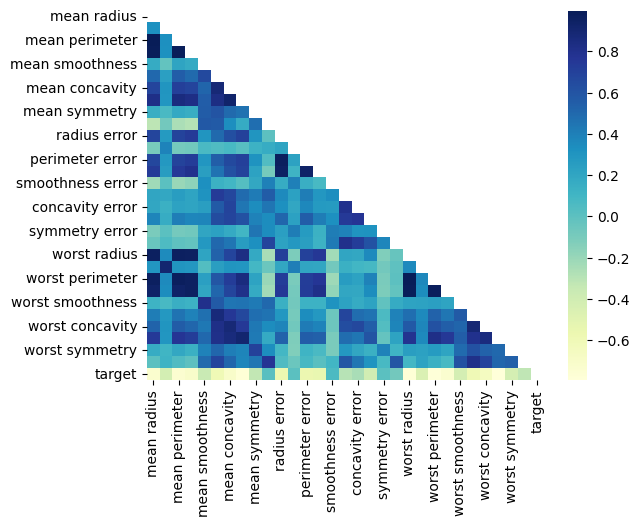

In [4]:
%matplotlib inline
mask = np.triu(np.ones_like(df.corr()))
sns.heatmap(df.corr(), cmap="YlGnBu", mask=mask)

## split data

In [5]:
X, y = df.drop('target', axis=1), df.target # predict cancer
X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X_train.shape, X_test.shape)

(426, 30) (143, 30)


## set up logistic regression model

In [6]:
lr = LogisticRegression(random_state=42, max_iter=1000).fit(X_train, y_train)
f1_score(y_test, lr.predict(X_test))

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.9723756906077349

## set up random forest model

In [7]:
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)
f1_score(y_test, rf.predict(X_test))

0.9720670391061453

## compare models using McNamar   
**Result: FAIL to reject H0**


**mcnemar_table returns**
```
tb : array-like, shape=[2, 2]

2x2 contingency table with the following contents: a: tb[0, 0]: # of samples that both models predicted correctly b: tb[0, 1]: # of samples that model 1 got right and model 2 got wrong c: tb[1, 0]: # of samples that model 2 got right and model 1 got wrong d: tb[1, 1]: # of samples that both models predicted incorrectly
```
see: https://rasbt.github.io/mlxtend/user_guide/evaluate/mcnemar_table/  

In [8]:
tb = mcnemar_table(y_test, lr.predict(X_test), rf.predict(X_test))
tb

array([[136,   2],
       [  2,   3]])

## Do the models disagree?
**H0**: There is very little difference in the disagreements between the two models.

In [9]:
# calculate mcnemar test
result = mcnemar(tb, exact=True)

# summarize the finding
print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))
# interpret the p-value

alpha = 0.05
if result.pvalue > alpha:
 print('Same proportions of errors (FAIL to reject H0)')
else:
 print('Different proportions of errors (REJECT H0)')

statistic=2.000, p-value=1.000
Same proportions of errors (FAIL to reject H0)


## Examine which feature was most important

**plot the impurity-based importance**  
**Warning** Impurity-based feature importances can be misleading for high cardinality features (many unique values).  
see: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [10]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

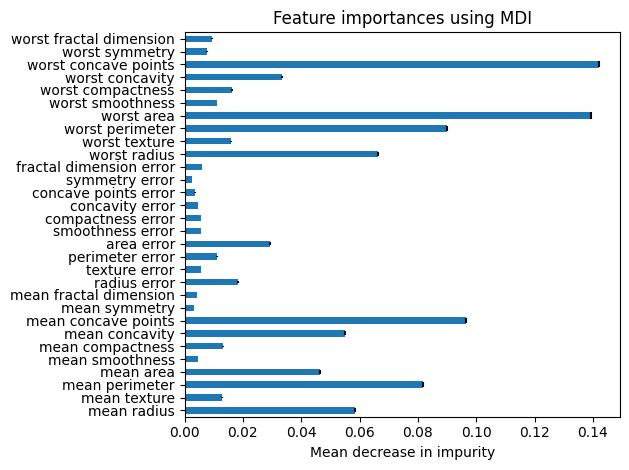

In [11]:
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.barh(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_xlabel("Mean decrease in impurity")
fig.tight_layout()

**plot importance based on feature permutation**  
see: https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html  
Permutation feature importance overcomes limitations of the impurity-based feature importance: they do not have a bias toward high-cardinality features and can be computed on a left-out test set.  

In [12]:
result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
forest_importances_perm = pd.Series(result.importances_mean, index=X.columns)

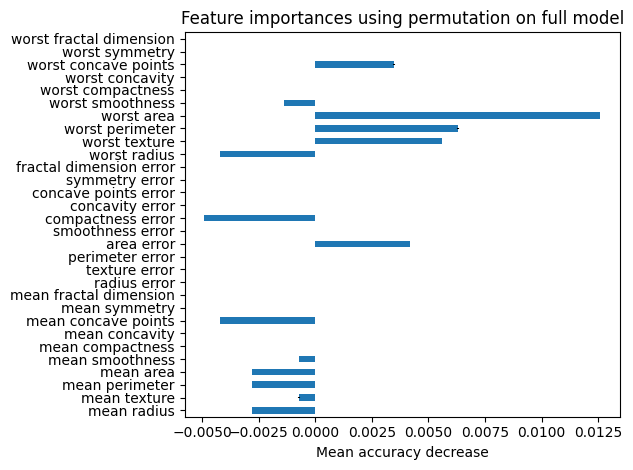

In [13]:
fig, ax = plt.subplots()
forest_importances_perm.plot.barh(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_xlabel("Mean accuracy decrease")
fig.tight_layout()

## SHAP values for feature importance

In [14]:
# need to change int and bool to classes int_ and bool_ to handle error 'numpy' has no attribute 'int'/'bool'/etc.
np.bool = np.bool_
np.int = np.int_
np.float = np.float_

In [15]:
explainer = shap.TreeExplainer(rf, X_train)

In [16]:
shap_values = explainer(X_test)

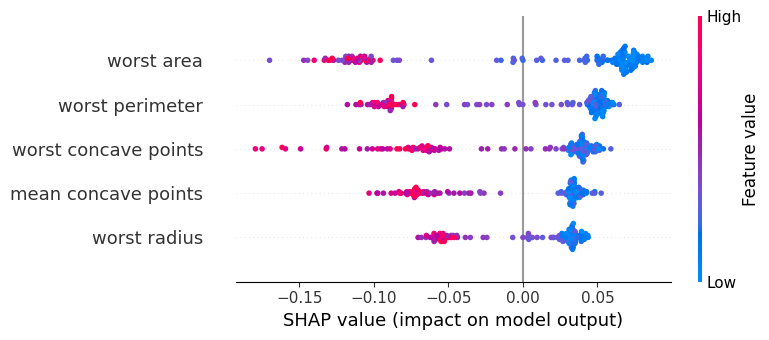

In [17]:
shap.summary_plot(shap_values[:, :, 1], X_test, max_display=5)

scatter plot show lower values  of `worst area` correlate with postive diagnosis.

<Axes: xlabel='worst area', ylabel='target'>

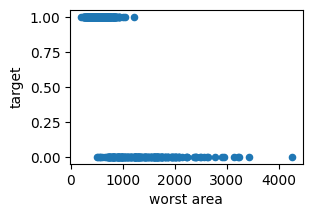

In [18]:
df.plot.scatter(x='worst area', y='target', figsize=(3,2))

## remove `worst area` and test with McNamar
**Result: REJECT H0**

In [19]:
X_drop, y = df.drop(['worst area', 'target'], axis=1), df.target # predict cancer
X_train_drop, X_test_drop, y_train_drop, y_test_drop = train_test_split(X_drop, y)
print(X_train_drop.shape, X_test_drop.shape)

(426, 29) (143, 29)


In [20]:
rf_drop = RandomForestClassifier(random_state=42).fit(X_train_drop, y_train_drop)
f1_score(y_test_drop, rf_drop.predict(X_test_drop))

0.970059880239521

In [21]:
tb_drop = mcnemar_table(y_test, rf.predict(X_test), rf_drop.predict(X_test_drop))
tb_drop

array([[68, 70],
       [ 0,  5]])

In [22]:
# calculate mcnemar test
result_drop = mcnemar(tb_drop, exact=True)

# summarize the finding
print('statistic=%.3f, p-value=%.3f' % (result_drop.statistic, result_drop.pvalue))
# interpret the p-value

alpha = 0.05
if result_drop.pvalue > alpha:
 print('Same proportions of errors (FAIL to reject H0)')
else:
 print('Different proportions of errors (REJECT H0)')

statistic=0.000, p-value=0.000
Different proportions of errors (REJECT H0)
